Hannah Weiser <br>
January 2023 <br>
Master's thesis
***
# Metric estimation from simulated point clouds

This notebook aims at estimating tree metrics from simulated point clouds of static and of moving trees. For now, it's shown exemplary for one tree point cloud.
The following metrics are included:
* Leaf area (using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427))
* Leaf area index (using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427)
* Canopy openness and LAI using simulated digital hemispherical photographs using [Gap Light Analyzer (GLA) Software](https://www.caryinstitute.org/science/our-scientists/dr-charles-d-canham/gap-light-analyzer-gla) ([Seidel et al. 2012](https://doi.org/10.1016/j.agrformet.2011.10.006))

* Leaf angles/Leaf angle distribution

* Geometric features based on eigenvalues

* Voxel-based metrics (e.g., number/ratio of empty voxels/empty enclosed voxels, points per voxel, etc.)

* Tree/crown metrics???

## Imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import laspy
import pandas as pd
from descartes import PolygonPatch
from alphashape import alphashape
from scripts import plot

## Merge and load Point Cloud

In [2]:
# hardcode for now
pc_dir = r"H:\helios\output\moving_tree10_tls\2023-01-23_13-34-00"
survey_name = Path(pc_dir).parent.name
path_merged_pc = (Path(pc_dir) / f"{survey_name}.laz")

if not path_merged_pc.exists():
    print(f"Executing command:\nlasmerge -i {pc_dir}/*.laz -o {path_merged_pc.as_posix()} -faf")
    ! lasmerge -i {pc_dir}/*.laz -o {path_merged_pc.as_posix()} -faf
else:
    print(f"{path_merged_pc.as_posix()} already exists.")

H:/helios/output/moving_tree10_tls/2023-01-23_13-34-00/moving_tree10_tls.laz already exists.


In [3]:
las = laspy.read(path_merged_pc)

coords = np.array([las.x, las.y, las.z]).T
classification = np.array([las.classification])
coords_leaves = coords[(classification == 1)[0], :]
coords_wood = coords[(classification == 0)[0], :]

## Plot Point Cloud

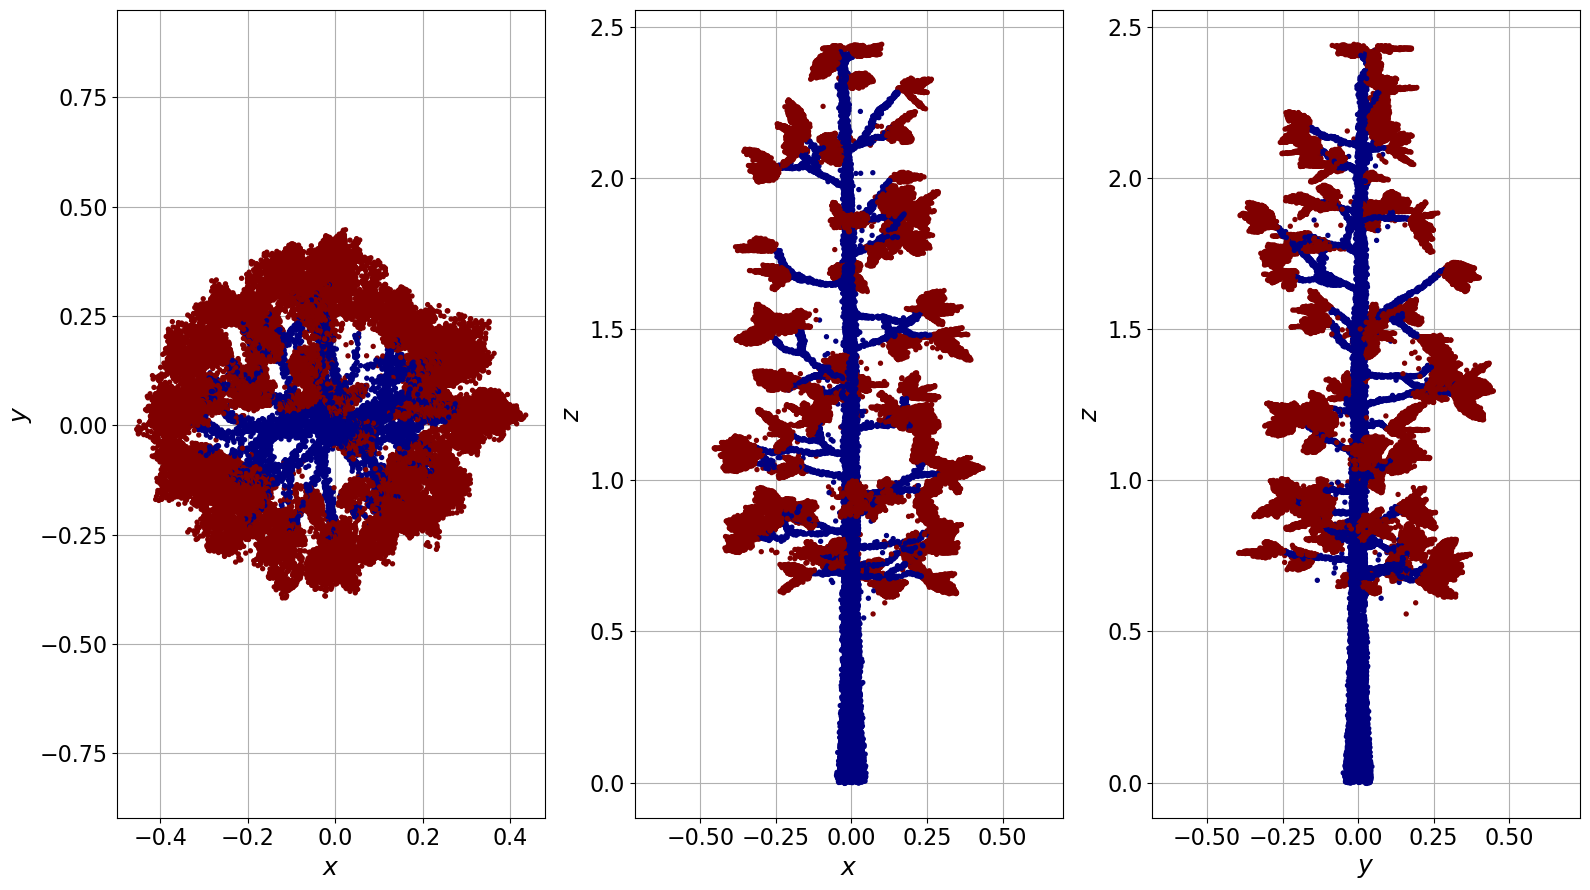

In [4]:
plot.plot_2dviews(coords[::10, :], c=classification[0][::10], s=8)

## 3D Alpha Shape

In [5]:
alpha = 70.0
alpha_shp = alphashape(coords_leaves, alpha)
alpha_shp.show()

In [6]:
print(f"One-sided leaf area calculated from alpha shape: {alpha_shp.area/2:.4f} m2")

One-sided leaf area calculated from alpha shape: 1.3663 m2


## 2D Convex Hull

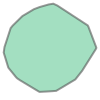

In [7]:
# convex hull is an alpha shape with alpha = 0.0
convex_hull_projected = alphashape(coords_leaves[::10, :2], 0.0)
convex_hull_projected

## 2D Concave Hull

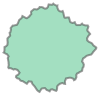

In [8]:
# convex hull is an alpha shape with alpha = 0.0
concave_hull_projected = alphashape(coords_leaves[::10, :2], 50.0)
concave_hull_projected

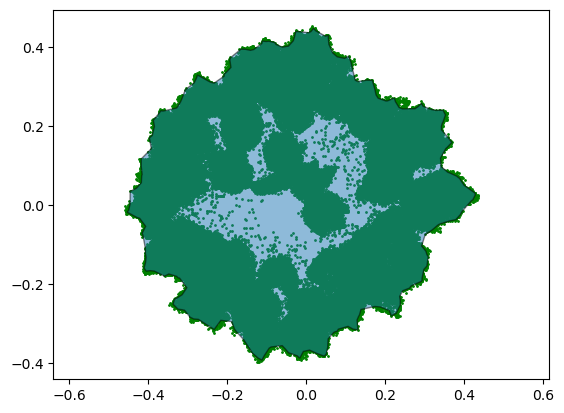

Area of the 2D alpha shape: 0.4673 m2


In [9]:
from shapely.geometry import Polygon, mapping
fig, ax = plt.subplots()
ax.scatter(coords_leaves[:, 0], coords_leaves[:, 1], s=1.0, c="green")
ax.add_patch(PolygonPatch(mapping(concave_hull_projected), alpha=0.5))
plt.axis("equal")
plt.show()
print(f"Area of the 2D alpha shape: {concave_hull_projected.area:.4f} m2")

## Leaf Area Index (LAI)
Using the Envelope Fitting method by [You et al. 2022](https://doi.org/10.1109/LGRS.2022.3214427)

In [10]:
print(f"{alpha_shp.area / concave_hull_projected.area:.4f}")

5.8480


## Leaf angles/Leaf angle distribution

tbd

## Geometric features

In [11]:
from jakteristics import las_utils, compute_features

In [12]:
features_jakteristics = ['planarity', 'linearity', 'sphericity', 'verticality']
search_radius = 0.05  # check; maybe compute for several search radii
n_threads = 4
dim_features = compute_features(coords_leaves, search_radius=search_radius, num_threads=n_threads,
                                feature_names=features_jakteristics)

### Plot geometric features

#### Planarity

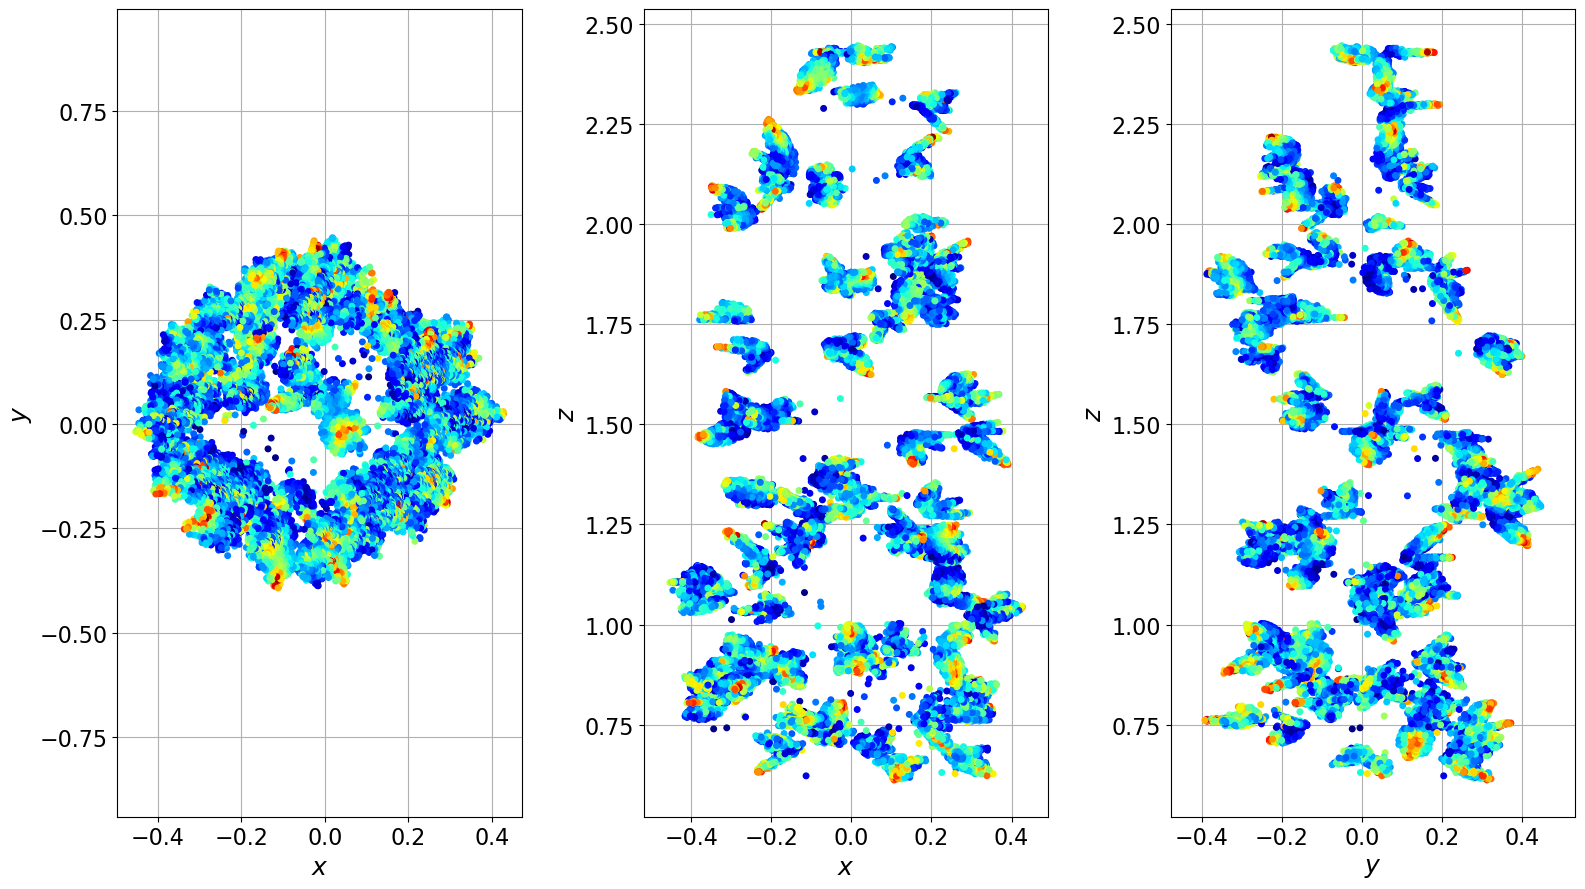

In [13]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 0])

#### Linearity

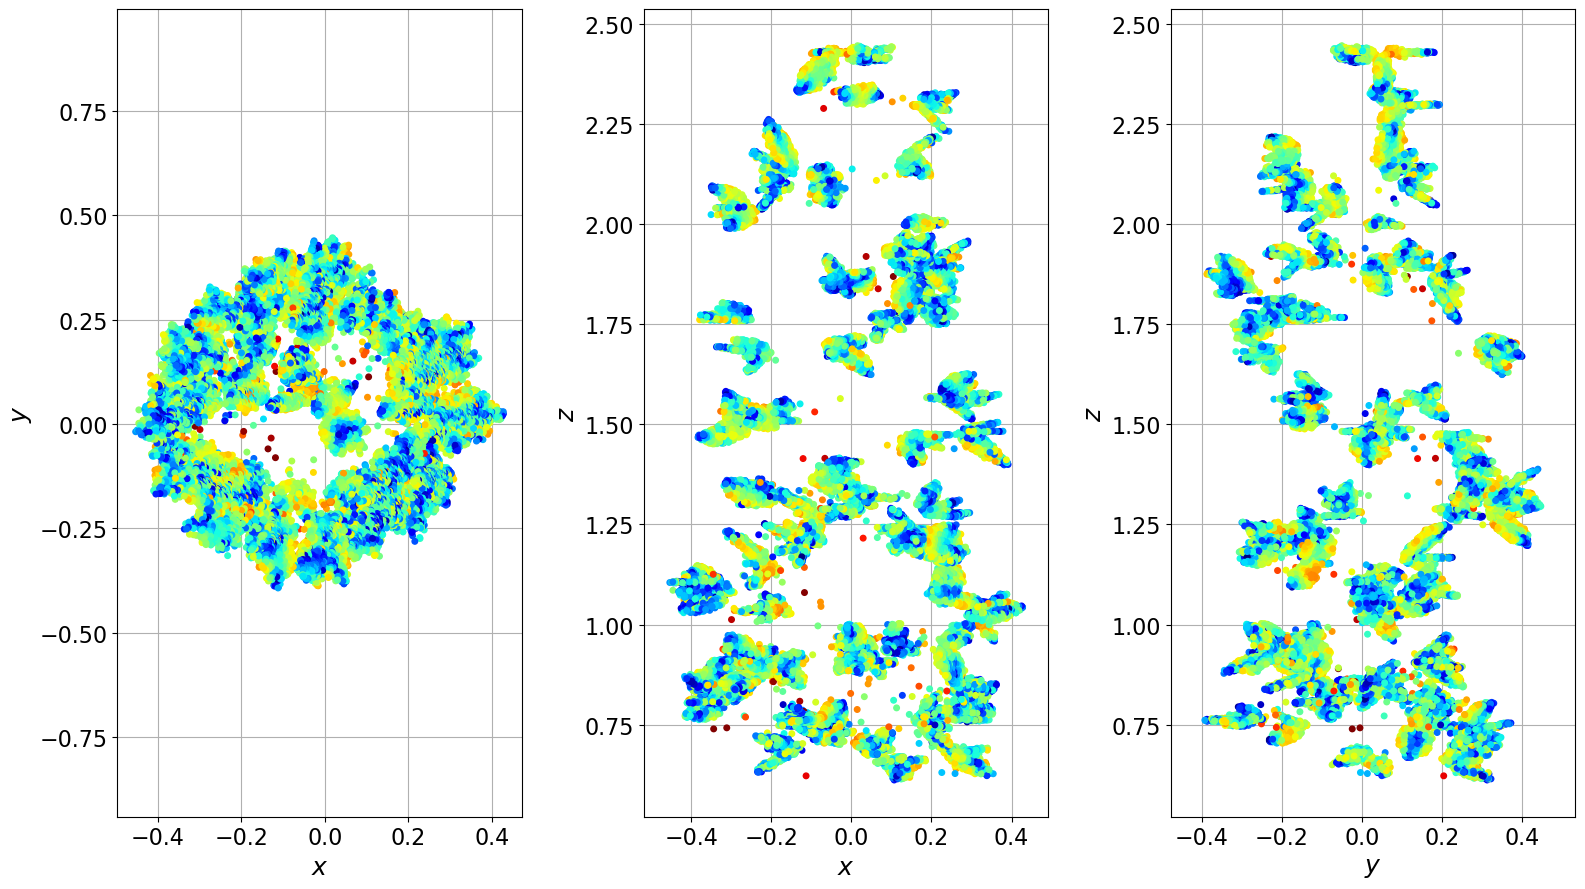

In [14]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 1])

#### Sphericity

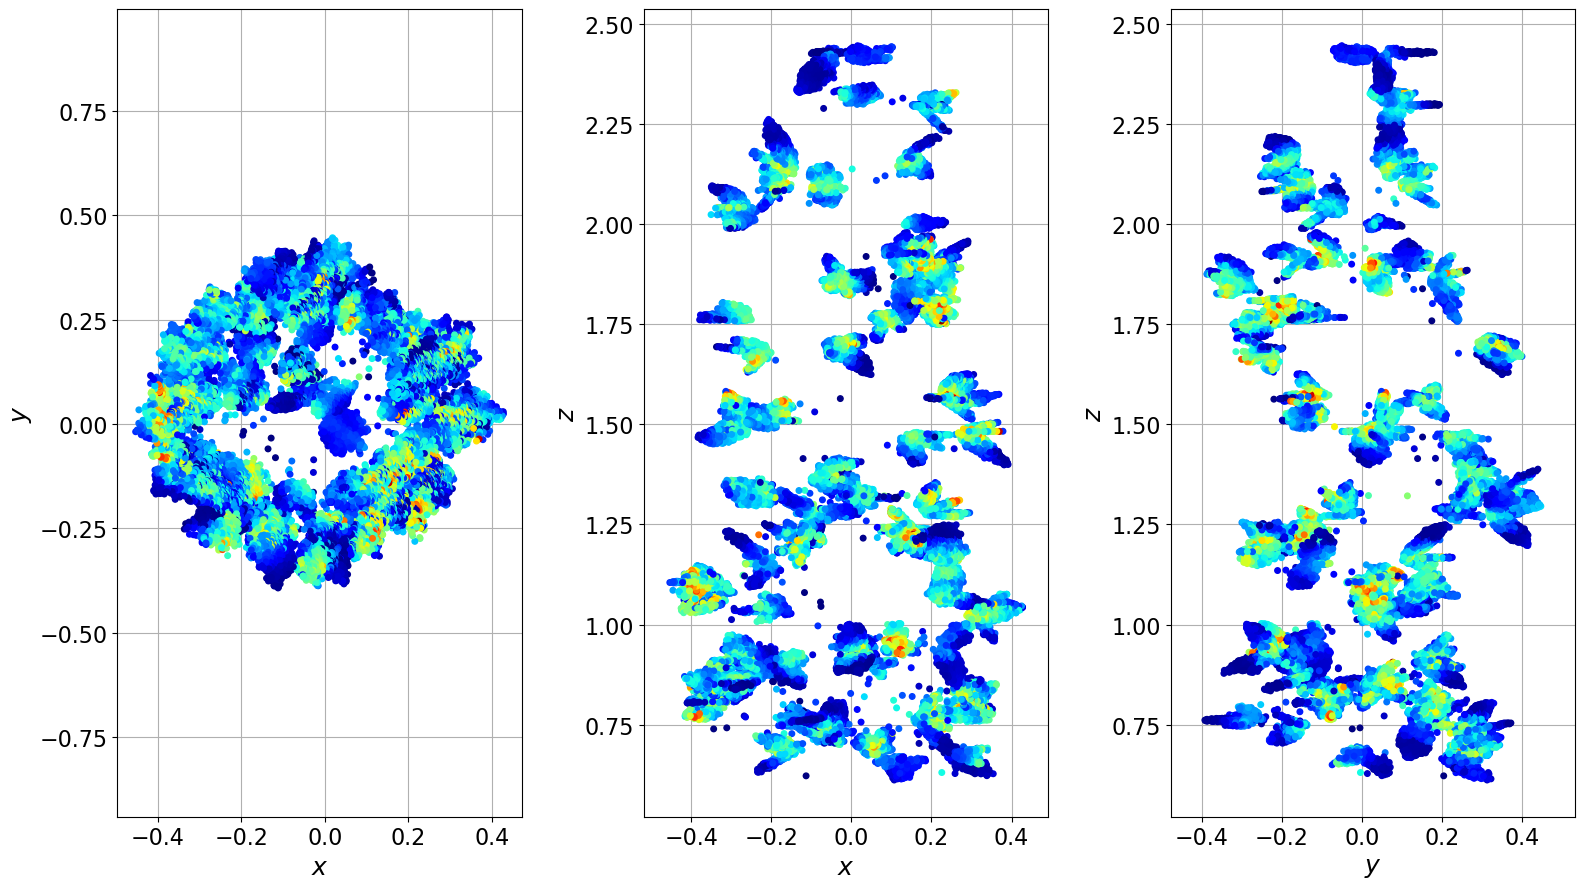

In [15]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 2])

#### Verticality

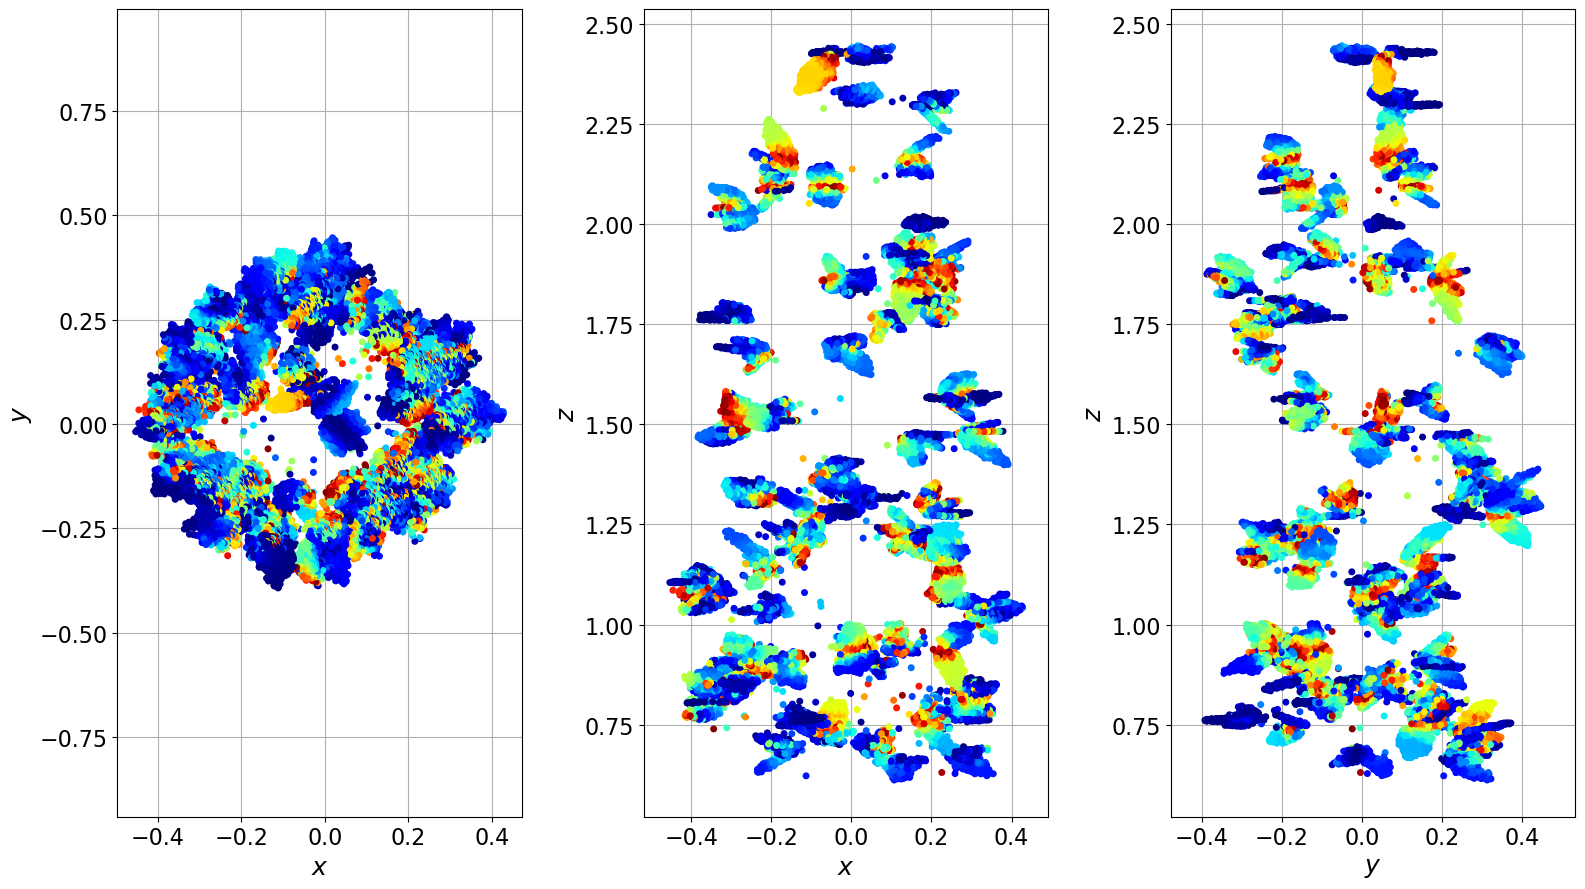

In [16]:
plot.plot_2dviews(coords_leaves[::10, :], c=dim_features[::10, 3])

### Summary statistics of geometric features

In [17]:
import pandas as pd

In [18]:
dim_feats_df = pd.DataFrame(dim_features, columns=features_jakteristics)

In [19]:
dim_feats_df.head()

planarity  linearity  sphericity  verticality
0   0.281428   0.425488    0.293083     0.172258
1   0.325325   0.371977    0.302698     0.146589
2   0.314038   0.390424    0.295538     0.162782
3   0.297180   0.429643    0.273177     0.189473
4   0.273695   0.472908    0.253398     0.229072

In [20]:
print(f"Mean:\n{dim_feats_df.mean()}\n")
print(f"Median:\n{dim_feats_df.median()}\n")
print(f"Standard deviation:\n{dim_feats_df.std()}\n")

Mean:
planarity      0.326117
linearity      0.408734
sphericity     0.265149
verticality    0.369165
dtype: float32

Median:
planarity      0.304810
linearity      0.415994
sphericity     0.259251
verticality    0.313013
dtype: float32

Standard deviation:
planarity      0.172539
linearity      0.157921
sphericity     0.150984
verticality    0.272418
dtype: float32



## Voxel-based features

### Ratio of filled to empty voxels

In [21]:
from scripts import voxelizer

In [22]:
vox_size = 0.05
vox = voxelizer.Voxelizer(coords, voxel_size=vox_size)
centers, idxs, voxel_idx, closest_idx, local_origin = vox.voxelize()

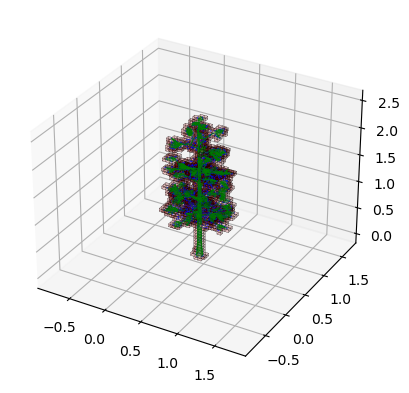

In [23]:
voxelizer.plot_result(coords, voxel_idx, closest_idx, vox_size, vox_size, vox_size, local_origin)

In [24]:
mins = np.min(voxel_idx, axis=0)
maxes = np.max(voxel_idx, axis=0)
x_range = int((maxes[0] - mins[0]) / 1) + 1
y_range = int((maxes[1] - mins[1]) / 1) + 1
z_range = int((maxes[2] - mins[2]) / 1) + 1
# prepare some coordinates
voxels = np.zeros((x_range, y_range, z_range), bool)
for idx in voxel_idx:
    idxlist = (idx - mins).astype(int).tolist()
    voxels[idxlist[0], idxlist[1], idxlist[2]] = True

In [25]:
print(f"{np.count_nonzero(voxels)} of {np.size(voxels)} voxels ({vox_size} m | {vox_size} m | {vox_size} m) in voxel space contain points.")
print(f"Percentage of filled voxels: {np.count_nonzero(voxels)/np.size(voxels)*100:.2f}%")

2152 of 17100 voxels (0.05 m | 0.05 m | 0.05 m) in voxel space contain points.
Percentage of filled voxels: 12.58%
